In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import numpy as np
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import psycopg2
from sklearn.preprocessing import StandardScaler
import pycountry_convert as pc
from dotenv import load_dotenv
import os 


load_dotenv(dotenv_path=rf'Data_ETL\.env')

OW_api_key = os.getenv('OW_api_key')
db_name = os.getenv('db_name')
db_user = os.getenv('user')
db_pass = os.getenv('password')
db_host = 'localhost'
db_port = os.getenv('port')

In [3]:

# Connect to the PostgreSQL database
conn = psycopg2.connect(dbname=db_name, user=db_user, password=db_pass, host=db_host, port=db_port)
cursor = conn.cursor()


def sql_to_dataframe(conn, query):
   '''
   Import data from a PostgreSQL database using a SELECT query 
   '''
   cursor = conn.cursor()
   cursor.execute(query)
   tuples_list = cursor.fetchall()
   cursor.close()
   column_names = [desc[0] for desc in cursor.description]
   df = pd.DataFrame(tuples_list, columns= column_names)
   
   return df

# Load all the data from the tables
cities_query = 'SELECT * FROM cities'
Cities_df = sql_to_dataframe(conn , cities_query)

weather_query = 'SELECT * FROM weather'
Weather_df = sql_to_dataframe(conn , weather_query)

pollution_query = 'SELECT * FROM pollution'
Pollution_df = sql_to_dataframe(conn , pollution_query)

#Change resolution of date_time to hour
Weather_df['date_time_hour'] = Weather_df['date_time'].dt.ceil(freq='h')  
Pollution_df['date_time_hour'] = Pollution_df['date_time'].dt.ceil(freq='h')  
#Merge dfs
merged_df = Weather_df.merge(Pollution_df, how='inner', left_on=['city_id', 'date_time_hour'], right_on=['city_id', 'date_time_hour'])


In [4]:
#Load WHO Data
who_data_raw = pd.read_csv(rf'Data\Raw\WHO Data.csv')

country_list = set(Cities_df['country_iso'])
who_data_filtered = who_data_raw[who_data_raw['SpatialDimValueCode'].isin(country_list)]

rename_and_keep = {'SpatialDimValueCode':'country_iso', 'Location':'country',  'Period':'year', 'Dim1':'sex', 'Dim2':'cause', 'FactValueNumeric':'deaths'}

who_data_filtered  = who_data_filtered.rename(columns=rename_and_keep)
who_data_filtered  = who_data_filtered [list(rename_and_keep.values())]

who_data = who_data_filtered.merge( Cities_df[['country_iso', 'city_id','city_name']],how='inner', on='country_iso')

who_data.to_csv(rf'Data\Who Data.csv',index=False)


Exploratory Data Analysis 

In [5]:
#Check for Null values in important columns and drop those rows
merged_df.info()
merged_df.dropna(subset=['temperature','pm2_5','pm10'],inplace = True)
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   weather_id           234 non-null    int64         
 1   city_id              234 non-null    int64         
 2   date_time_x          234 non-null    datetime64[ns]
 3   local_time_x         234 non-null    datetime64[ns]
 4   temperature          231 non-null    float64       
 5   feels_like           234 non-null    float64       
 6   temp_min             228 non-null    float64       
 7   temp_max             204 non-null    float64       
 8   pressure             234 non-null    int64         
 9   humidity             234 non-null    int64         
 10  visibility           234 non-null    int64         
 11  wind_speed           204 non-null    float64       
 12  wind_deg             234 non-null    int64         
 13  clouds_all           234 non-null  

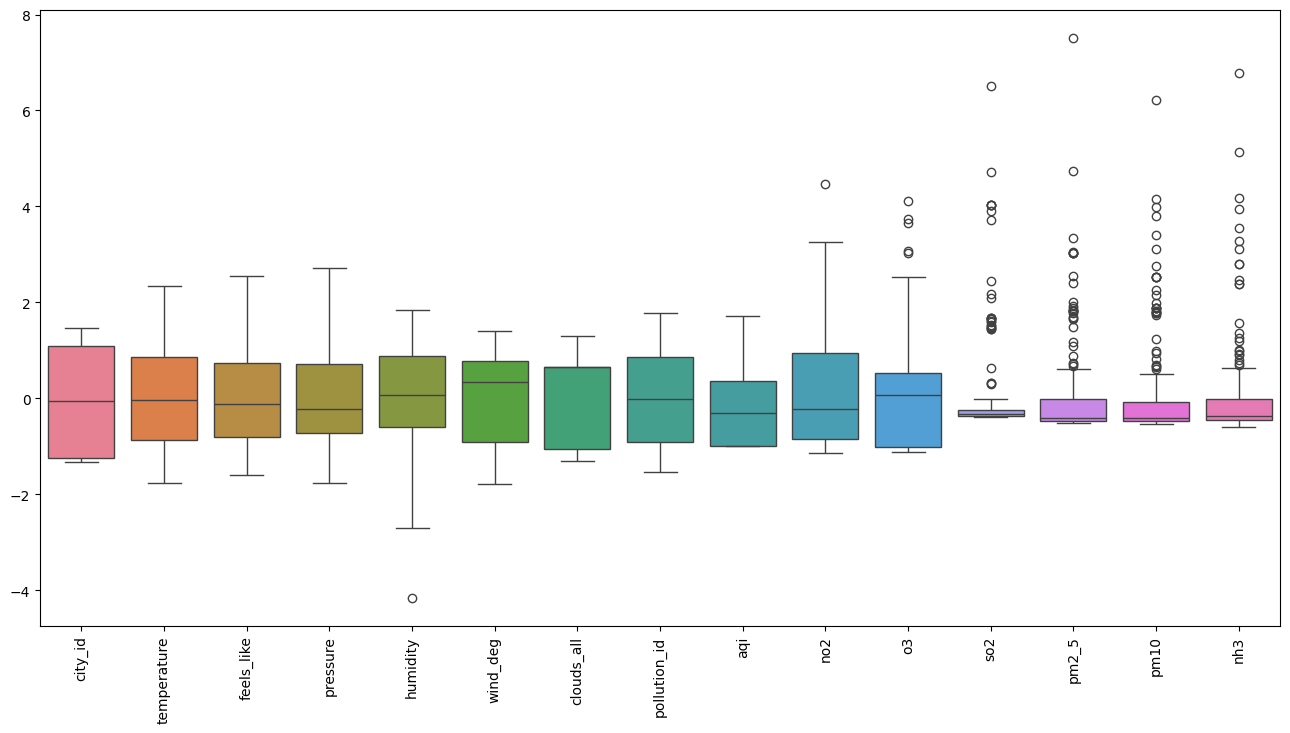

In [6]:
numerical_df = merged_df.select_dtypes('number')
numerical_df.drop(columns=['weather_id','temp_min','temp_max','no','co','visibility','wind_speed'],inplace=True)

scaler = StandardScaler()
numerical_df[numerical_df.columns]=scaler.fit_transform(numerical_df[numerical_df.columns])

fig, axes = plt.subplots(figsize=(16,8))
sns.boxplot(ax = axes, data= numerical_df)
axes.tick_params(axis='x', labelrotation=90)


In [7]:
Q1 = numerical_df.quantile(0.25)
Q3 = numerical_df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((numerical_df < lower_bound) | (numerical_df > upper_bound))
outliers_sum = outliers.sum()
print("Outliers detected:\n", outliers_sum)

filtered_df = numerical_df[~outliers.any(axis=1)]

Outliers detected:
 city_id          0
temperature      0
feels_like       0
pressure         0
humidity         1
wind_deg         0
clouds_all       0
pollution_id     0
aqi              0
no2              1
o3               5
so2             28
pm2_5           29
pm10            32
nh3             23
dtype: int64


I will retain the outliers in the data, as they may represent extreme values for certain measures in each city. These outliers could help identify cities with significantly higher pollution levels than others.

In [8]:
# Define the population ranges (bins) and corresponding labels (bands) and use pd.cut to create the population_band column
bins = [0, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000, 35000000, 400000000]
labels = [1, 2, 3, 4, 5, 6, 7, 8]
Cities_df['population_band'] = pd.cut(Cities_df['population'], bins=bins, labels=labels, right=False)

def get_continent_code(country_code):
        return pc.country_alpha2_to_continent_code(country_code)

Cities_df['continent'] = Cities_df['country'].apply(get_continent_code)


#Assign a categorical value for continets for groupby 
continent_mapping = { 'AS': 1,  'EU': 2,   'NA': 3 , 'OC':4}
Cities_df['continent_num'] = Cities_df['continent'].map(continent_mapping)
Cities_df['continent_num'] = Cities_df['continent_num'].astype('category')

new_merged_df = merged_df.merge(Cities_df, how='inner', left_on=['city_id'], right_on=['city_id'])


Analysis 

Pollution level per City

In [9]:
cities_name_and_id = dict(zip(Cities_df['city_id'], Cities_df['city_name']))

# Group by city and calculate mean
groupby_city = new_merged_df.select_dtypes(exclude=['object', 'datetime', 'bool'])
groupby_city = groupby_city.drop(columns=['continent_num', 'population_band'])
groupby_city = groupby_city.groupby('city_id', observed=False).mean().reset_index()

plot_who_data = who_data[(who_data['sex']=='Both sexes') & (who_data['cause']=='Total')]
groupby_city = groupby_city.merge(plot_who_data,how='inner', on='city_id')


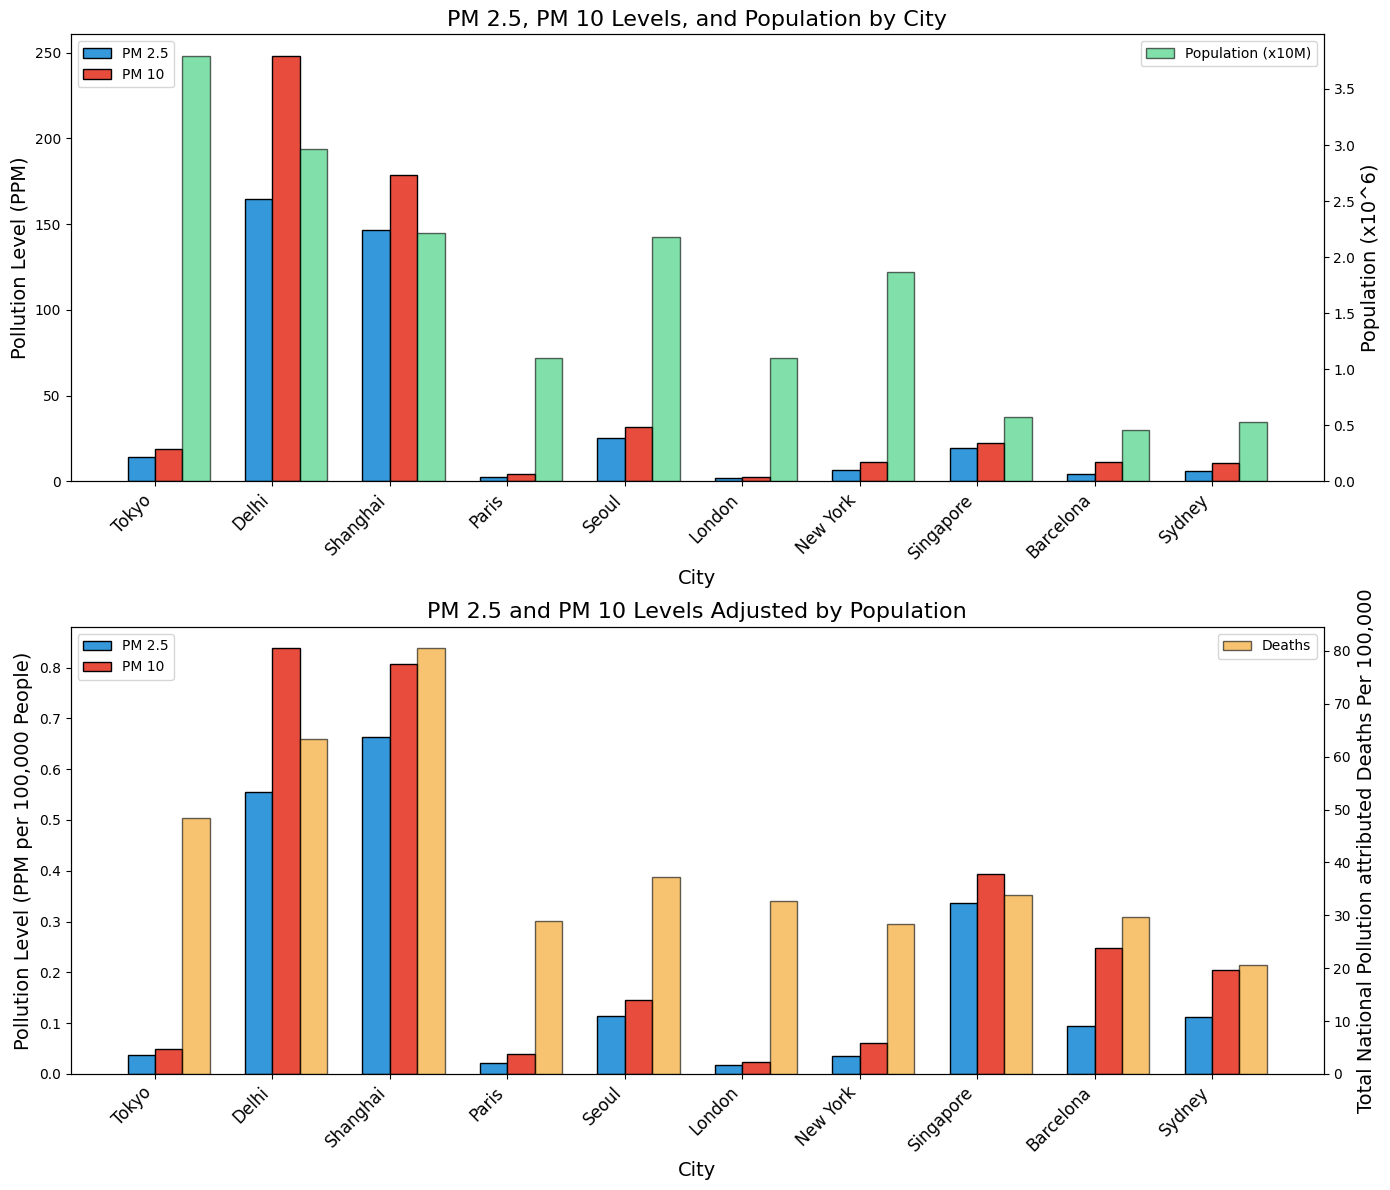

In [10]:
# Create subplots
fig1, ax1 = plt.subplots(2, 1, figsize=(14, 12))

x1 = groupby_city['city_id']
y1 = groupby_city['pm2_5']
y2 = groupby_city['pm10']
y3 = groupby_city['population']

# Extract city names using city_id and map to city_name
x_labels = [cities_name_and_id[num] for num in x1]

# Increase spacing between x-ticks
X_axis = np.arange(len(x1)) * 1.5
width = 0.35  # Bar width

# Plot PM 2.5 and PM 10 bars for the first plot
bar1 = ax1[0].bar(X_axis - width / 2, y1, width=width, label='PM 2.5', color='#3498db', edgecolor='black')
bar2 = ax1[0].bar(X_axis + width / 2, y2, width=width, label='PM 10', color='#e74c3c', edgecolor='black')

# Create a second y-axis for population
ax2 = ax1[0].twinx()
bar3 = ax2.bar(X_axis + width * 1.5, y3 / 10000000, width=width, label='Population (x10M)', color='#2ecc71', edgecolor='black', alpha=0.6)

# Set title and labels for the first plot
ax1[0].set_title('PM 2.5, PM 10 Levels, and Population by City', fontsize=16)
ax1[0].set_xlabel('City', fontsize=14)
ax1[0].set_ylabel('Pollution Level (PPM)', fontsize=14)

ax2.set_ylabel('Population (x10^6)', fontsize=14)

# Set x-ticks and labels for both axes
ax1[0].set_xticks(X_axis)
ax1[0].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)

# Add legends for both axes
ax1[0].legend([bar1, bar2], ['PM 2.5', 'PM 10'], loc='upper left')
ax2.legend([bar3], ['Population (x10M)'], loc='upper right')

# Second plot: PM 2.5, PM 10 levels adjusted by population
y1_2 = groupby_city['pm2_5'] * (100000 / groupby_city['population'])
y2_2 = groupby_city['pm10'] * (100000 / groupby_city['population'])
y3_2 = groupby_city['deaths']* (100000 / groupby_city['national_population'])

# Plot PM 2.5 and PM 10 bars for the second plot
bar4 = ax1[1].bar(X_axis - width / 2, y1_2, width=width, label='PM 2.5', color='#3498db', edgecolor='black')
bar5 = ax1[1].bar(X_axis + width / 2, y2_2, width=width, label='PM 10', color='#e74c3c', edgecolor='black')

# Create a second y-axis for deaths
ax2_1 = ax1[1].twinx()
bar6 = ax2_1.bar(X_axis + width * 1.5, y3_2, width=width, label='National Pollution attributed Deaths Per 100,00', color='#f39c12', edgecolor='black', alpha=0.6)

# Set title and labels for the second subplot
ax1[1].set_title('PM 2.5 and PM 10 Levels Adjusted by Population', fontsize=16)
ax1[1].set_xlabel('City', fontsize=14)
ax1[1].set_ylabel('Pollution Level (PPM per 100,000 People)', fontsize=14)

ax1[1].set_xticks(X_axis)
ax1[1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax2_1.set_ylabel('Total National Pollution attributed Deaths Per 100,000', fontsize=14)

# Add legends for the second plot
ax1[1].legend([bar4, bar5], ['PM 2.5', 'PM 10'], loc='upper left')
ax2_1.legend([bar6], ['Deaths'], loc='upper right')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


While Delhi and Shanghai have almost double the pollution levels of the third-ranked Singapore, their pollution levels relative to their populations are roughly comparable to those of Singapore, Barcelona, and Sydney. Conversely, the other half of the cities—such as Tokyo, London, New York, Seoul, and Paris—exhibit significantly lower pollution levels despite their larger populations. This suggests that the infrastructure in these cities may contribute to a substantial reduction in pollutant levels, even with their high populations.

In terms of relative deaths, the national-level data collection makes it challenging to draw accurate conclusions regarding the correlation between deaths and air pollution.




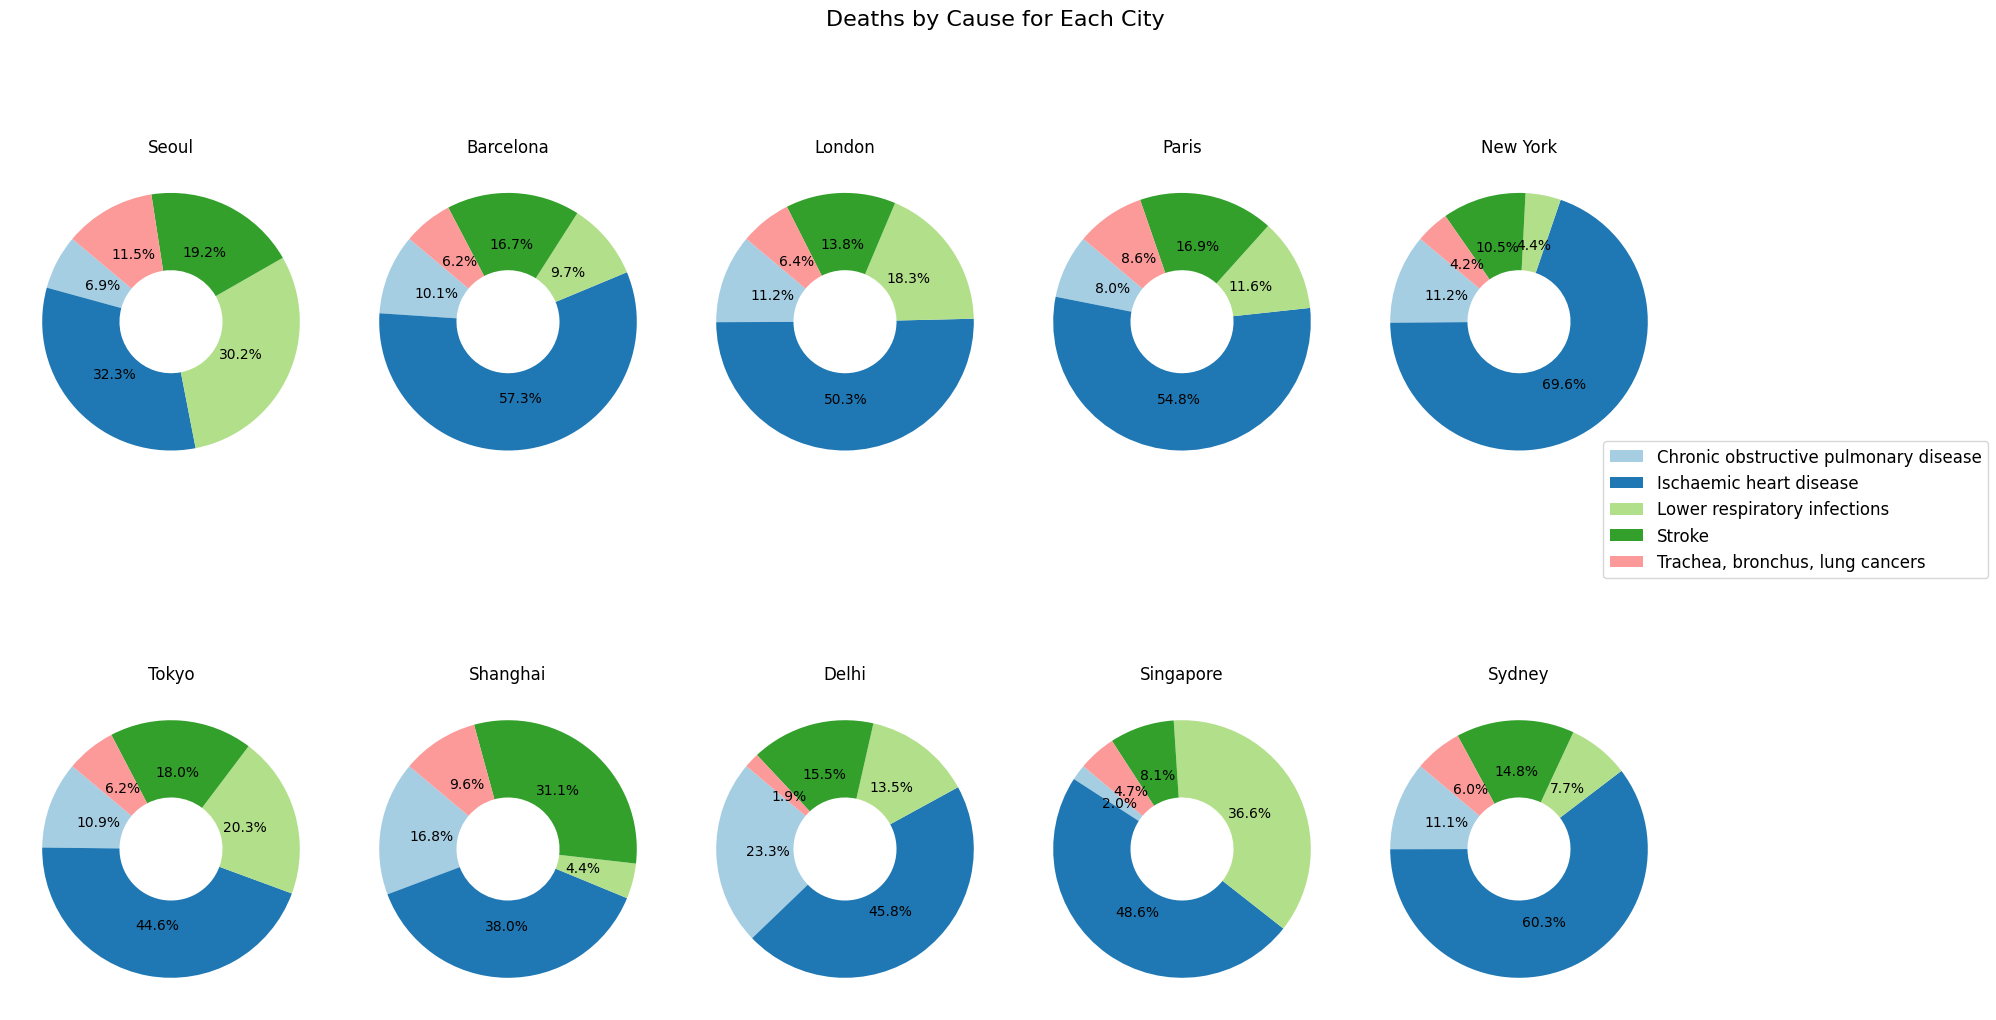

In [11]:
pie_chart_who_data = who_data[(who_data['cause']!='Total') & (who_data['sex']=='Both sexes')]
pie_chart_who_data

num_cities = pie_chart_who_data['city_name'].nunique()
cols = 5  
rows = 2  

colors = sns.color_palette('Set2', n_colors=pie_chart_who_data['cause'].nunique())

fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
axes = axes.flatten()

# Plot each pie chart with percentages
for i, city in enumerate(pie_chart_who_data['city_name'].unique()):

    city_data = pie_chart_who_data[pie_chart_who_data['city_name'] == city]
    cause_deaths = city_data.groupby('cause')['deaths'].sum()
    
    # Create donut chart in the appropriate subplot with percentage labels
    wedges, texts, autotexts = axes[i].pie(
        cause_deaths, 
        autopct='%1.1f%%',  
        startangle=140,
        wedgeprops={'width': 0.6}, 
        colors=plt.cm.Paired.colors
    )
    
    axes[i].set_title(f'{city}', fontsize=12)
    
    # Adjust the font size of the percentage labels
    for autotext in autotexts:
        autotext.set_fontsize(10)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(wedges, cause_deaths.index, loc='center right', fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])  
fig.suptitle('Deaths by Cause for Each City', fontsize=16)

plt.show()


The leading cause of deaths related to atmospheric diseases appears to be ischemic heart disease, particularly in New York (69.6%) and Sydney (60.3%). Lower respiratory infections account for only 30.2% of deaths in Seoul and 36.8% in Singapore, whereas in New York and Shanghai, lower respiratory deaths constitute just 4.4% of their totals.

Pollution vs Population/Continent

In [12]:
#Count function for plotting values on barchart
pop_count = new_merged_df.groupby('population_band',observed=False)['city_id'].nunique().to_dict()
con_count = new_merged_df.groupby('continent_num',observed=False)['city_id'].nunique().to_dict()


#groupby population bands 
groupby_population = new_merged_df.select_dtypes(exclude=['object','datetime','bool'])
groupby_population = groupby_population.drop(columns = 'continent_num')
groupby_population = groupby_population.groupby('population_band',observed=False ).mean().reset_index()

#Groupby Continets
groupby_continent = new_merged_df.select_dtypes(exclude=['object','datetime','bool'])
groupby_continent = groupby_continent.drop(columns = ['population_band'])
groupby_continent = groupby_continent.groupby('continent_num',observed=False).mean().reset_index()


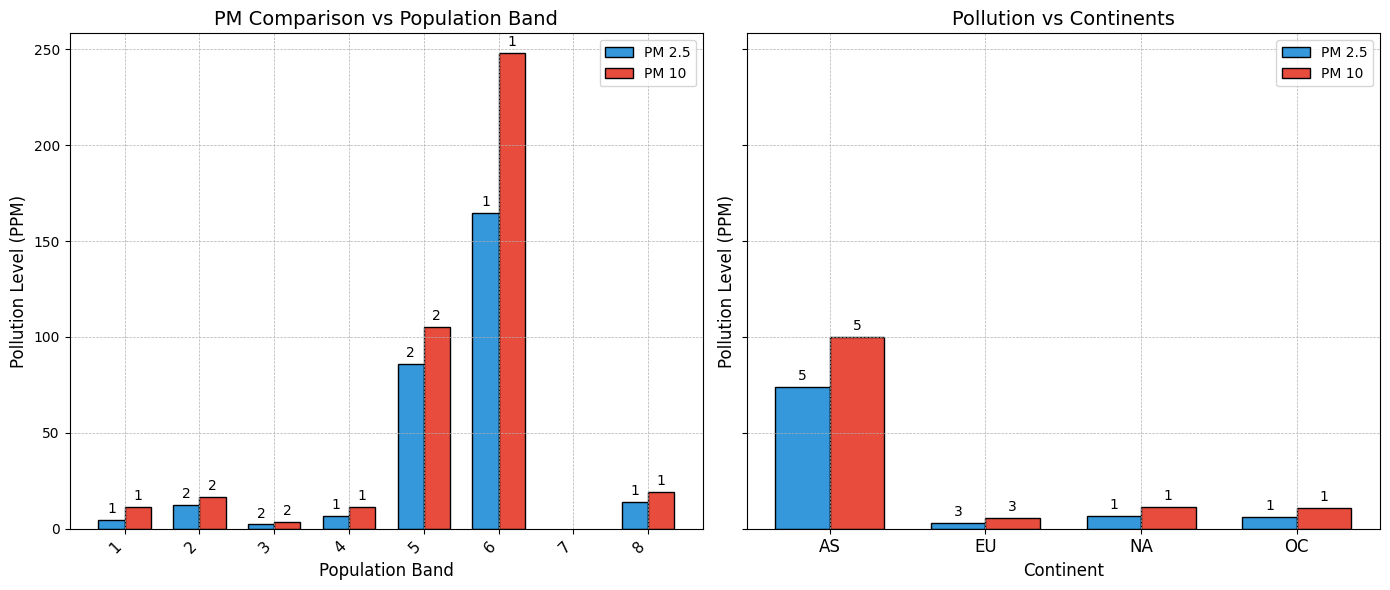

In [13]:
# Population Bands Plot
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

x1 = groupby_population['population_band']
y1 = groupby_population['pm2_5']
y2 = groupby_population['pm10']

X_axis = np.arange(len(x1.unique()))  
width = 0.35  # Adjust the width to better space out the bars

# Plot PM vs Population Band
bars1 = ax2[0].bar(X_axis - width/2, y1, width=width, label='PM 2.5', color='#3498db', edgecolor='black')
bars2 = ax2[0].bar(X_axis + width/2, y2, width=width, label='PM 10', color='#e74c3c', edgecolor='black')

ax2[0].set_title('PM Comparison vs Population Band', fontsize=14)
ax2[0].set_xlabel('Population Band', fontsize=12)
ax2[0].set_ylabel('Pollution Level (PPM)', fontsize=12)
ax2[0].set_xticks(X_axis)
ax2[0].set_xticklabels(x1.unique(), rotation=45, ha='right', fontsize=11)
ax2[0].legend()

# Annotate bars with counts
for i, bar in enumerate(bars1):
    population_band = x1.unique()[i]
    count = pop_count.get(population_band, 0)
    ax2[0].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10, color='black')

for i, bar in enumerate(bars2):
    population_band = x1.unique()[i]
    count = pop_count.get(population_band, 0)
    ax2[0].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10, color='black')

# Define continent mapping
continent_mapping = {1: 'AS', 2: 'EU', 3: 'NA', 4: 'OC'}
x2_labels = [continent_mapping[num] for num in sorted(continent_mapping.keys())]

y3 = groupby_continent['pm2_5']
y4 = groupby_continent['pm10']

X_axis_2 = np.arange(len(x2_labels))

# Plot PM vs Continent
bars3 = ax2[1].bar(X_axis_2 - width/2, y3, width=width, label='PM 2.5', color='#3498db', edgecolor='black')
bars4 = ax2[1].bar(X_axis_2 + width/2, y4, width=width, label='PM 10', color='#e74c3c', edgecolor='black')

ax2[1].set_title('Pollution vs Continents', fontsize=14)
ax2[1].set_xlabel('Continent', fontsize=12)
ax2[1].set_ylabel('Pollution Level (PPM)', fontsize=12)
ax2[1].set_xticks(X_axis_2)
ax2[1].set_xticklabels(x2_labels, fontsize=12)
ax2[1].legend()

# Annotate bars with counts
for i, bar in enumerate(bars3):
    continent_num = sorted(continent_mapping.keys())[i]
    count = con_count.get(continent_num, 0)
    ax2[1].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10, color='black')

for i, bar in enumerate(bars4):
    continent_num = sorted(continent_mapping.keys())[i]
    count = con_count.get(continent_num, 0)
    ax2[1].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10, color='black')

# Set the same y-limit for better comparison
max_y = max(max(y1.max(), y2.max()), max(y3.max(), y4.max()))
ax2[0].set_ylim(0, max_y + 10)

# Add gridlines for better readability
ax2[0].grid(True, which='major', linestyle='--', linewidth=0.5)
ax2[1].grid(True, which='major', linestyle='--', linewidth=0.5)

# Improve layout and aesthetics
plt.tight_layout()
plt.show()
